In [64]:
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.QuadOptimizer.multi_plane_fast import MultiplaneFast
from lenstronomy.LensModel.QuadOptimizer.param_manager import PowerLawFreeShear
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.wcs import WCS
from astropy.visualization import SqrtStretch, imshow_norm, LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from scipy.interpolate import griddata
from scipy.signal import convolve2d
from scipy.optimize import minimize
import matplotlib.pylab as pylab
from photutils import DAOStarFinder
from astropy.stats import sigma_clipped_stats
from astropy.cosmology import Planck15, FlatLambdaCDM
from dynesty import DynamicNestedSampler
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc
from scipy.optimize import linprog
from multiprocessing import Pool
from corner import corner
from matplotlib import cm
import emcee
from astropy.constants import c


params = {'legend.fontsize': 'x-large',
#           'figure.figsize': (10, 10),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
plt.style.use("science")

In [65]:
SNR = 5.098 # known from original fits file
galfit_data = fits.open("../data/blocks1.fits")
im = galfit_data[3].data
wcs= WCS(galfit_data[1].header)
psf = fits.open("../data/rxj1131_psf1.fits")[0].data
im[im < 0] = 0
image_principales = np.loadtxt("../data/images_positions.txt")[:4] ## B, A, C, D, G, S

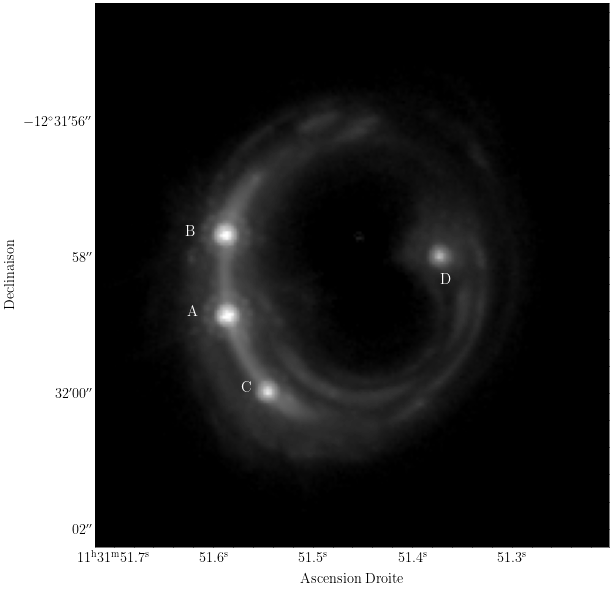

In [66]:
plt.figure(figsize=(10, 10))
plt.subplot(projection=wcs)
plt.imshow(im, cmap="gray", norm=ImageNormalize(stretch=LogStretch()))#, norm=ImageNormalize(stretch=SqrtStretch()))
ax = plt.gca()
ox, oy = image_principales[:, 0], image_principales[:, 1]
ax.annotate("A",  [ox[1]-15, oy[1]], color="w", fontsize=15)
ax.annotate("B",  [ox[0]-15, oy[0]], color="w", fontsize=15)
ax.annotate("C",  [ox[2]-10, oy[2]], color="w", fontsize=15)
ax.annotate("D",  [ox[3], oy[3]-10], color="w", fontsize=15)
# ax.annotate("G",  [ox[4], oy[4]-10], color="w", fontsize=15)
# ax.annotate("S",  [ox[5], oy[5]+5], color="w", fontsize=15)
ax.set_xlabel('Ascension Droite')
ax.set_ylabel('Declinaison');
plt.savefig("../latex/beamer_lens/figures/residual.png")

In [67]:
# Trouver la position des 4 images principales
mean, median, std = sigma_clipped_stats(im,  sigma=3.0)
print(mean, median, std)
daofind = DAOStarFinder(fwhm=3.0, threshold=5.*std)
image_principales = daofind(im).to_pandas().sort_values("flux", ascending=False).iloc[:7]
image_principales

0.017546648 0.0 0.034847353


,id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
13,14,47.630071,114.149930,0.421323,-0.140638,-0.164836,25,0.0,123.906906,604.727832,-6.953900
8,9,48.316470,84.484198,0.459638,0.277774,-0.305937,25,0.0,121.668182,503.413541,-6.754812
3,4,63.115152,56.540868,0.687271,0.069577,0.076066,25,0.0,65.747673,269.003839,-6.074396
12,13,126.250540,106.427980,0.665696,0.205851,0.011222,25,0.0,17.827728,72.637033,-4.652895
15,16,49.969234,120.091233,0.520219,-0.945623,0.909310,25,0.0,2.570759,3.417144,-1.334158
5,6,59.059255,63.378521,0.450558,-0.808945,0.501900,25,0.0,1.953708,3.413539,-1.333012
2,3,69.797401,53.207256,0.566567,-0.269242,-0.217103,25,0.0,1.992010,3.344478,-1.310821


In [68]:
# make a pixel grid and find center pixel
N, M = im.shape
y = np.arange(N) #- N//2. + 0.5 * ((N + 1) % 2)
x = np.arange(M) #- M//2. + 0.5 * ((M + 1) % 2)
x, y = np.meshgrid(x, y)
lens_sky = wcs.pixel_to_world(x.ravel(), y.ravel())
x_center = (lens_sky.ra[M//2]).to(u.arcsec)
y_center = (lens_sky.dec[M*N//2]).to(u.arcsec)

In [69]:
lens_sky.ra[M//2].to(u.hourangle)

<Longitude 11.53096118 hourangle>

In [70]:
lens_sky.dec[M*N//2]

<Latitude -12.53284535 deg>

In [71]:
x_image = image_principales["xcentroid"].to_numpy()
y_image = image_principales["ycentroid"].to_numpy()
positions = wcs.pixel_to_world(x_image, y_image)
x_image = (positions.ra - x_center).to(u.arcsec).value
y_image = (positions.dec - y_center).to(u.arcsec).value
image_position = pd.DataFrame(np.column_stack([x_image[[1, 0, 2, 3]], y_image[[1, 0, 2, 3]]]), columns=["theta_x", "theta_y"])
image_position.to_csv("../data/image_positions.csv")

In [72]:
image_position

,theta_x,theta_y
0,1.871755,-0.620745
1,1.899811,0.565885
2,1.265423,-1.738513
3,-1.321753,0.256831


In [73]:

def NIE_backward_model(params, x_image, y_image):
#     x0l, y0l, e, phi, x_c, r_ein = params
    x0l, y0l, e, phi, r_ein = params
    x_c = 0.1
    # x0l : ra of lens (in as)
    # y0l: dec of lens (in as)
    # r_ein: Einstein radius (in mas)
    # e: ellipticity parameter
    # phi: orientation of the lens [0, pi]
    # x_c: central radius
    # x0, y0: position of the source
    # width: width of the source
    def psi(grid):
        theta1 = grid[:, 0]
        theta2 = grid[:, 1]
        return np.sqrt(1/(1 - e)*theta1**2 + (1 - e)*theta2**2 + x_c**2)

    def grad_psi(grid):
        theta1 = grid[:, 0]
        theta2 = grid[:, 1]
        p = psi(grid)
        grad1 =  r_ein * theta1 / p / (1 - e)
        grad2 =  r_ein * (1 - e) * theta2 / p
        return np.column_stack([grad1, grad2])

    def rotate(grid, phi):
        rho = np.hypot(grid[:, 0], grid[:, 1])
        varphi = np.angle(grid[:, 0] + 1j*grid[:, 1]) - phi
        rotated_theta1 = rho * np.cos(varphi)
        rotated_theta2 = rho * np.sin(varphi)
        return np.column_stack([rotated_theta1, rotated_theta2])
    
    theta = np.column_stack([x_image, y_image])
    theta = rotate(theta, phi)
    theta1 = theta[:, 0] - x0l
    theta2 = theta[:, 1] - y0l
    theta = np.column_stack([theta1, theta2])
    
    alpha = grad_psi(theta) # deflection angles
    beta  = theta - alpha # lens equation
    return beta

def likelihood(params, x_image, y_image, tolerance):
    beta = NIE_backward_model(params, x_image, y_image)
    betax = beta[:, 0]
    betay = beta[:, 1]
    dx_source = sum([(betax[i] - betax[j])**2 for i in range(3) for j in range(i + 1, 4)])
    dy_source = sum([(betay[i] - betay[j])**2 for i in range(3) for j in range(i + 1, 4)])
    chi_squared = -0.5 * (dx_source + dy_source) / tolerance**2
    return chi_squared

In [74]:
x0l = 0.1
y0l = 0.1
e = 0.1
phi = 0.3
x_c = 0.1
r_ein = 1.6
# params =  [x0l, y0l, e, phi, x_c, r_ein]
params = [x0l, y0l, e, phi, r_ein]
tolerance = 0.005
likelihood(params, x_image, y_image, tolerance)

-26344.322281701356

In [75]:
bounds = [
    [-1, 1], #x0l
    [-1, 1], # y0l
    [0., 0.4], # e
    [0, np.pi], # phi
#     [0, 1], #x_c 
    [0, 5], # r_ein
]

def prior_transform(x, bounds=bounds): # uniform distribution
    return [(bounds[i][1] - bounds[i][0]) * x[i] + bounds[i][0] for i in range(x.size)]

def loglike(x):
    return likelihood(x, x_image, y_image, tolerance)

# ndim = len(bounds)
# with Pool(8) as pool:
#     sampler = DynamicNestedSampler(loglike, prior_transform, ndim, pool=pool, queue_size=10, nlive=3000)
#     sampler.run_nested()
#     res1 = sampler.results
#     sampler.run_nested()
#     res2 = sampler.results

In [76]:
# dyplot.runplot(res2)

In [77]:
# fig, axs = dyplot.traceplot(sampler.results, show_titles=True,
#                              trace_cmap='plasma', connect=True,
#                              connect_highlight=range(5),
#                             labels=[r"$x_{0\ell}$", r"$y_{0\ell}$", r"$e$", r"$\phi$", r"$\theta_c$", r"$\theta_E$"]
#                            );
# fig.tight_layout(pad=2.0)
# plt.savefig("quasar_image_samples.png")

In [78]:
# fig, axes = plt.subplots(4, 4, figsize=(15, 15))
# axes.reshape([4, 4])
# add white space
# [a.set_frame_on(False) for a in axes[:, 2]]
# [a.set_xticks([]) for a in axes[:, 2]]
# [a.set_yticks([]) for a in axes[:, 2]]

# plot initial run (res1; left)
# fg, ax = dyplot.cornerpoints(sampler.results, cmap='plasma', kde=False, fig=(fig, axes), 
#                              labels=[r"$x_{0\ell}$", r"$y_{0\ell}$", r"$e$", r"$\phi$", r"$\theta_c$", r"$\theta_E$"])

In [79]:
# fig, axes = plt.subplots(5, 5, figsize=(15, 15))
# axes.reshape([5, 5])
# add white space
# [a.set_frame_on(False) for a in axes[:, 2]]
# [a.set_xticks([]) for a in axes[:, 2]]
# [a.set_yticks([]) for a in axes[:, 2]]

# plot initial run (res1; left)
# fg, ax = dyplot.cornerplot(sampler.results, fig=(fig, axes), color="b",
#                              labels=[r"$x_{0\ell}$", r"$y_{0\ell}$", r"$e$", r"$\phi$", r"$\theta_c$", r"$\theta_E$"],
#                           show_titles=True)
# plt.savefig("../latex/beamer_lens/figures/corner_plot.png")

In [80]:
def NIE_forward_model(params, source_grid, lens_grid):
    x0l, y0l, e, phi, x_c, r_ein, x0, y0, width = params
    # x0l : ra of lens (in as)
    # y0l: dec of lens (in as)
    # r_ein: Einstein radius (in mas)
    # e: ellipticity parameter
    # phi: orientation of the lens [0, pi]
    # x_c: central radius
    # x0, y0: position of the source
    # width: width of the source
    params = [{
        "theta_E": r_ein,
        "gamma": 2,
        "e1": e,
        "e2": 0,
        "s_scale": x_c,
        "center_x": x0l,
        "center_y": y0l
         }]
    def psi(grid):
        theta1 = grid[:, 0]
        theta2 = grid[:, 1]
        return np.sqrt(1/(1 - e)*theta1**2 + (1 - e)*theta2**2 + x_c**2)

    def grad_psi(grid):
        theta1 = grid[:, 0]
        theta2 = grid[:, 1]
        p = psi(grid)
        grad1 =  r_ein * theta1 / p / (1 - e)
        grad2 =  r_ein * (1 - e) * theta2 / p
        return np.column_stack([grad1, grad2])

    def rotate(grid, phi):
        rho = np.hypot(grid[:, 0], grid[:, 1])
        varphi = np.angle(grid[:, 0] + 1j*grid[:, 1]) - phi
        rotated_theta1 = rho * np.cos(varphi)
        rotated_theta2 = rho * np.sin(varphi)
        return np.column_stack([rotated_theta1, rotated_theta2])

    def source_model(source_grid, x0, y0, width): # symmetric gaussian profile
        rho = np.hypot(source_grid[:, 0] - x0, source_grid[:, 1] - y0)
        return np.exp(-0.5*rho**2/width**2)/2/np.pi/width**2
    
    theta = rotate(lens_grid, phi)
    theta1 = theta[:, 0] - x0l
    theta2 = theta[:, 1] - y0l
    lens_grid = np.column_stack([theta1, theta2])
    
    alpha  = grad_psi(lens_grid) # deflection angles
    beta   = theta - alpha # lens equation
    I      = source_model(source_grid,  x0, y0, width)
    I_lens = griddata(source_grid, I, (beta[:, 0], beta[:, 1]), method="linear") # ray trace source profile to lens plane
    return I_lens


def likelihood_both(params, image, sigma_vector, psf, source_grid, lens_grid, pixel_map, x_image, y_image, dtheta):
    I_reconstructed = NIE_forward_model(params,  source_grid, lens_grid)
#     I_reconstructed += np.random.normal(0, sigma_vector.ravel(), size=I_reconstructed.shape)
    I_reconstructed = convolve2d(I_reconstructed.reshape(image.shape), psf, mode="same").ravel()
    chi_squared = -0.5 * np.mean((I_reconstructed[pixel_map] - image.ravel()[pixel_map])**2/sigma_vector**2)
    chi_squared +- likelihood(params[:-3], x_image, y_image, dtheta)
    return chi_squared

In [81]:
#lensgrid -> place center in the bottom left corner, not in the center of the image
N, M = im.shape
y = np.arange(N) #- N//2. + 0.5 * ((N + 1) % 2)
x = np.arange(M) #- M//2. + 0.5 * ((M + 1) % 2)
x, y = np.meshgrid(x, y)
rho = np.hypot(x, y)

In [82]:
# sky coordinate are relative to corner in pixel space
lens_sky = wcs.pixel_to_world(x.ravel(), y.ravel())
# place center in the middle of the array
x_lens = (lens_sky.ra - lens_sky.ra[M//2]).to(u.arcsec).value
y_lens = (lens_sky.dec - lens_sky.dec[M * N // 2]).to(u.arcsec).value
lens_grid = np.column_stack([x_lens.ravel(), y_lens.ravel()])
rho_lens = np.hypot(x_lens, y_lens)
fov = 2 * rho_lens.max()
fov

11.106699410950242

In [83]:
# make fov of source plane about half as small
fov_source = fov/2
# source grid
Ns = N//2 # also make grid with about 4 times less pixel
Ms = M//2
ys = np.linspace(-1, 1, Ns) * fov_source
xs = np.linspace(-1, 1, Ms) * fov_source
xs, ys = np.meshgrid(xs, ys)
source_grid = np.column_stack([xs.ravel(), ys.ravel()])

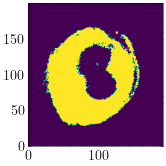

In [84]:
good_pixel_map = np.zeros_like(rho, dtype=bool)
good_pixel_map[im > 0.05] = True
plt.imshow(good_pixel_map, origin="lower")

In [85]:
# bounds = [ # informed from previous Nested Sampling call
#     [-0.4, 0], #x0l
#     [0, 1], # y0l
#     [0., 0.2], # e
#     [1, 1.5], # phi
#     [0.01, 1], #x_c 
#     [1, 5], # r_ein
#     [-0.2, 0.2], #x0
#     [0, 1], # y0
#     [0.01, 1] # width
# ]

# def prior_transform(x, bounds=bounds): # uniform distribution
#     return [(bounds[i][1] - bounds[i][0]) * x[i] + bounds[i][0] for i in range(x.size)]

# ndim = len(bounds)
# sigma = np.sqrt(im[good_pixel_map]*1000) # roughly a count
# def loglike(x):
#     return likelihood_both(x, im, sigma, psf, source_grid, lens_grid, good_pixel_map.ravel(), x_image, y_image, tolerance)
# res = nestle.sample(loglike, prior_transform, ndim=len(bounds), npoints=10)

# with Pool(8) as pool:
#     sampler = DynamicNestedSampler(loglike, prior_transform, ndim, pool=pool, queue_size=10, nlive=3000)
#     sampler.run_nested(maxiter=5000)

In [86]:
# dyplot.runplot(sampler.results)

In [87]:
# fig, axs = dyplot.traceplot(sampler.results, show_titles=True,
#                              trace_cmap='viridis', connect=True,
#                              connect_highlight=range(5),
#                             labels=[r"$x_{0\ell}$", r"$y_{0\ell}$", r"$e$", r"$\phi$", r"$\theta_c$", r"$\theta_E$", r"$x_{0s}$", r"$y_{0s}$", "$\sigma_s$"]
#                            );
# fig.tight_layout(pad=2.0)

In [88]:
speed_of_light = c.to(u.Mpc / u.day).value
speed_of_light

8.39428867311569e-10

AB =   +0.50

AC =   +0.00

AD =  -91.72

BC =   -0.50

BD =  -92.22

CD =  -91.72

In [89]:
delta_t = pd.DataFrame(np.array([[91.72, 0.7, -0.4], [1.5, 1.4, 2]]).T, columns=["delta_t", "sigma"])
delta_t.to_csv("../data/time_delays.csv")
delta_t

,delta_t,sigma
0,91.72,1.5
1,0.70,1.4
2,-0.40,2.0


In [90]:
results_dt = [91.72, 0.7, -.4] # days, DA, AB, CB
sigma_dt = [1.5, 1.4, 2]
D_dt_initial = 5000 # Mpc
x_c = 0.1
bounds = [
    [-1, 1], #x0l
    [-1, 1], # y0l
    [0., 0.3], # e
    [0, np.pi], # phi
#     [0, 1], #x_c 
    [0, 5], # r_ein
]
# beta_AGN = NIE_backward_model(res1.samples[np.argmax(res1.logl)], x_image, y_image).mean(axis=0)
arcsec2rad = np.pi/180/3600

def log_prior_Ddt(Ddt):
    if 0 < Ddt < 10000:
        return 0.0
    return -np.inf

def log_prior_lens(params):
    for i, p in enumerate(params[1:]):
        if not bounds[i][0] < p < bounds[i][1]:
            return -np.inf
    return 0.0

def log_prob(x):
#     Ddt, x0l, y0l, e, phi, x_c, r_ein = x#[x[:, i] for i in range(7)]
    Ddt, x0l, y0l, e, phi, r_ein = x
#     ll = log_prior_Ddt(Ddt)
#     ll += log_prior_lens(x)
#     if np.isinf(ll):
#         return ll

    def psi(grid):
        grid = np.atleast_2d(grid)
        theta1 = grid[:, 0]
        theta2 = grid[:, 1]
        return np.sqrt(1/(1 - e)*theta1**2 + (1 - e)*theta2**2 + x_c**2)

    def grad_psi(grid):
        theta1 = grid[:, 0]
        theta2 = grid[:, 1]
        p = psi(grid)
        grad1 =  r_ein * theta1 / p / (1 - e)
        grad2 =  r_ein * (1 - e) * theta2 / p
        return np.column_stack([grad1, grad2])

    def rotate(grid, phi):
        grid = np.atleast_2d(grid)
        rho = np.hypot(grid[:, 0], grid[:, 1])
        varphi = np.angle(grid[:, 0] + 1j*grid[:, 1]) - phi
        rotated_theta1 = rho * np.cos(varphi)
        rotated_theta2 = rho * np.sin(varphi)
        return np.column_stack([rotated_theta1, rotated_theta2])
    
    theta = np.column_stack([x_image, y_image])
    theta = rotate(theta, phi)
    theta1 = theta[:, 0] - x0l
    theta2 = theta[:, 1] - y0l
    theta = np.column_stack([theta1, theta2])
    pos_l = np.array([x0l, y0l])
    
    alpha = grad_psi(theta) # deflection angles
#     beta  = theta - alpha # lens equation
    
    # B, A, C, D
    B = 0
    A = 1
    C = 2
    D = 3
#     delta_t_model_AB = Ddt * (np.dot(beta_AGN - theta[A], beta_AGN - theta[A])/2 
#                               - np.dot(beta_AGN - theta[B], beta_AGN - theta[B])/2 
#                               - psi((rotate(theta[A], phi) - pos_l)/r_ein) + psi((rotate(theta[B], phi) - pos_l)/r_ein)) / speed_of_light * arcsec2rad**2
#     delta_t_model_DA = Ddt * (np.dot(beta_AGN - theta[D], beta_AGN - theta[D])/2 
#                           - np.dot(beta_AGN - theta[A], beta_AGN - theta[A])/2 
#                           - psi((rotate(theta[D], phi) - pos_l)/r_ein) + psi((rotate(theta[A], phi) - pos_l)/r_ein)) / speed_of_light * arcsec2rad**2
    dt_DA = Ddt * (np.dot(alpha[D], alpha[D])/2 - np.dot(alpha[A], alpha[A])/2 - r_ein * psi(theta[D]) + r_ein * psi(theta[A])) / speed_of_light * arcsec2rad**2
    dt_DB = Ddt * (np.dot(alpha[A], alpha[A])/2 - np.dot(alpha[B], alpha[B])/2 - r_ein * psi(theta[A]) + r_ein * psi(theta[B])) / speed_of_light * arcsec2rad**2
    dt_DC = Ddt * (np.dot(alpha[C], alpha[C])/2 - np.dot(alpha[B], alpha[B])/2 - r_ein * psi(theta[C]) + r_ein * psi(theta[B])) / speed_of_light * arcsec2rad**2
    dts = [dt_DA, dt_DB, dt_DC]
    ll = -0.5 * sum([(results_dt[i] - dts[i])**2/sigma_dt[i]**2 for i in range(3)])[0]
    ll += loglike(x[1:])
    return ll


In [91]:
p = [2400, 0.04, 0.6, 0.23, 1.24, 1.3]
log_prob(p)

-98480.42562877953

In [92]:
bounds = [
    [0, 10000],
    [-2, 2], #x0l
    [-2, 2], # y0l
    [0., 0.3], # e
    [0, np.pi], # phi
#     [0, 1], #x_c 
    [0, 5], # r_ein
]

def prior_transform(x, bounds=bounds): # uniform distribution
    return [(bounds[i][1] - bounds[i][0]) * x[i] + bounds[i][0] for i in range(len(bounds))]

ndim = len(bounds)
with Pool(8) as pool:
    sampler = DynamicNestedSampler(log_prob, prior_transform, ndim, pool=pool, queue_size=10, nlive=3000)
    sampler.run_nested()
    res_joint = sampler.results

36754it [01:35, 386.54it/s, batch: 9 | bound: 203 | nc: 1 | ncall: 179992 | eff(%): 20.420 | loglstar: -30.526 < -22.306 < -23.752 | logz: -55.654 +/-  0.341 | stop:  0.950]                 


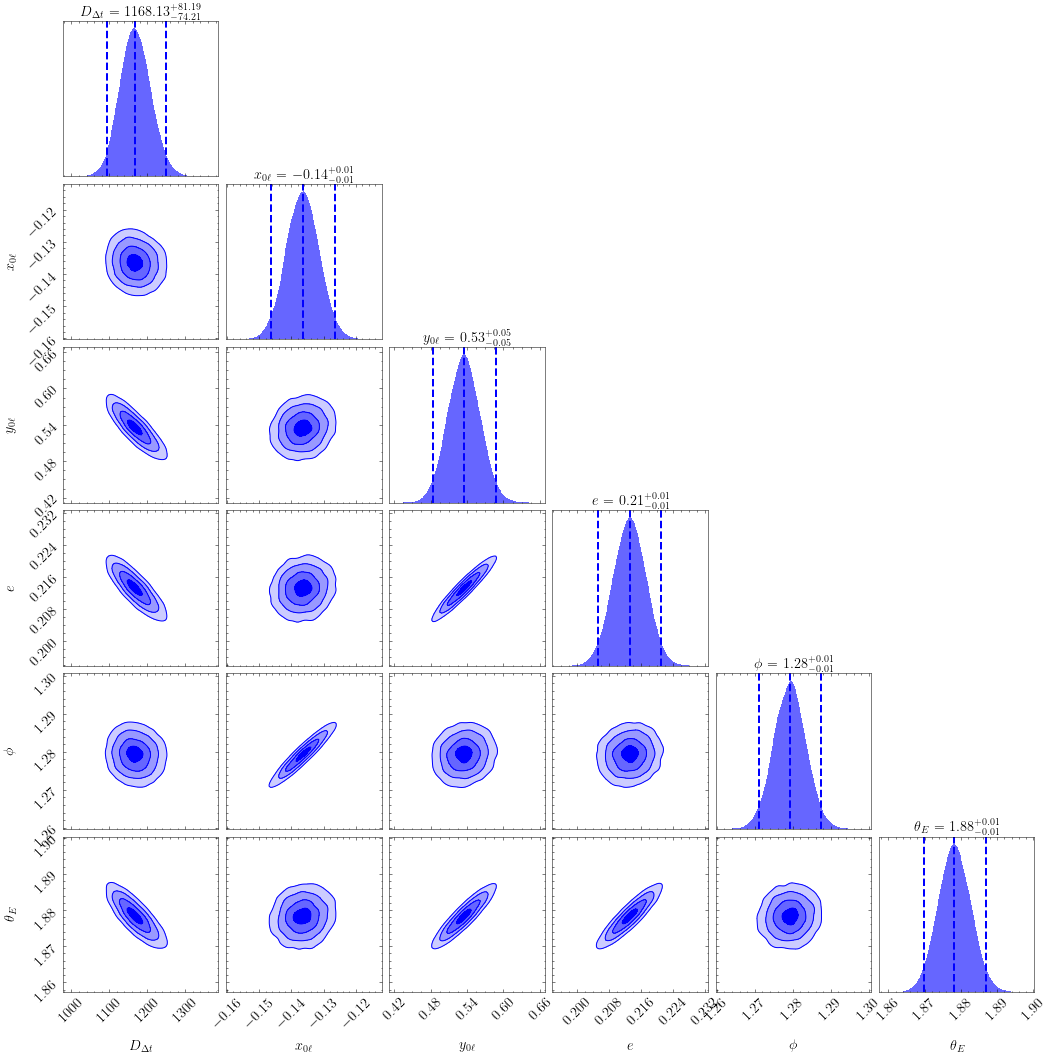

In [93]:
fig, axes = plt.subplots(6, 6, figsize=(15, 15))
axes.reshape([6, 6])
fg, ax = dyplot.cornerplot(res_joint, fig=(fig, axes), color="b",
                             labels=[r"$D_{\Delta t}$", r"$x_{0\ell}$", r"$y_{0\ell}$", r"$e$", r"$\phi$", r"$\theta_E$"],
                          show_titles=True)
plt.savefig("../latex/beamer_lens/figures/corner_plot_joint.png")

In [94]:
def weighted_quantile(values, quantiles, sample_weight=None, 
                      values_sorted=False, old_style=False):
    """ Very close to numpy.percentile, but supports weights.
    NOTE: quantiles should be in [0, 1]!
    :param values: numpy.array with data
    :param quantiles: array-like with many quantiles needed
    :param sample_weight: array-like of the same length as `array`
    :param values_sorted: bool, if True, then will avoid sorting of
        initial array
    :param old_style: if True, will correct output to be consistent
        with numpy.percentile.
    :return: numpy.array with computed quantiles.
    """
    values = np.array(values)
    quantiles = np.array(quantiles)
    if sample_weight is None:
        sample_weight = np.ones(len(values))
    sample_weight = np.array(sample_weight)
    assert np.all(quantiles >= 0) and np.all(quantiles <= 1), \
        'quantiles should be in [0, 1]'

    if not values_sorted:
        sorter = np.argsort(values)
        values = values[sorter]
        sample_weight = sample_weight[sorter]

    weighted_quantiles = np.cumsum(sample_weight) - 0.5 * sample_weight
    if old_style:
        # To be convenient with numpy.percentile
        weighted_quantiles -= weighted_quantiles[0]
        weighted_quantiles /= weighted_quantiles[-1]
    else:
        weighted_quantiles /= np.sum(sample_weight)
    return np.interp(quantiles, weighted_quantiles, values)

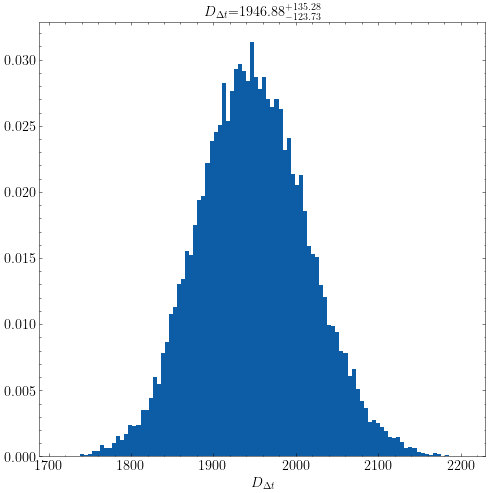

In [95]:
Ddt = res_joint.samples[:, 0]/0.6
weights = np.exp(res_joint['logwt'] - res_joint['logz'][-1])

low, ql, med, qh, high = weighted_quantile(Ddt, [0.0001, 0.025, 0.5, 0.975, 0.9999], weights)
error_plus = qh - med
error_minus = med - ql
good = (Ddt > low) & (Ddt < high)
Ddt = Ddt[good]
weights = weights[good]

plt.figure(figsize=(8, 8))
plt.hist(Ddt, bins=100, weights=weights);
plt.title(r"$D_{\Delta t}$=%.2f$^{+%.2f}_{-%.2f}$" % (med, error_plus, error_minus))
plt.xlabel(r"$D_{\Delta t}$");
plt.savefig("../latex/beamer_lens/figures/marginalized_posterior_Ddt.png")

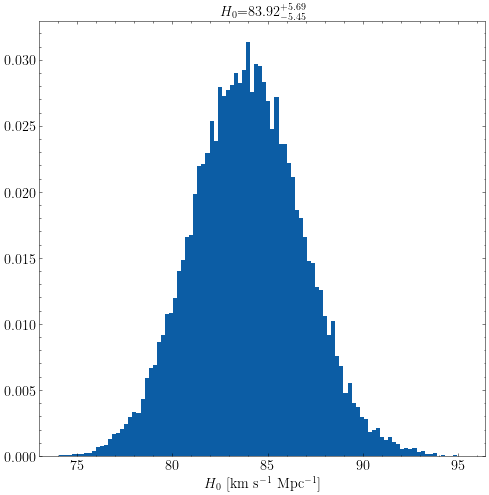

In [96]:
from scipy.integrate import quad
z_lens = 0.295
z_source = 0.654
omega_m = 0.3
omega_L = 0.7
def H(z):
    return 1/np.sqrt(omega_m * (1 + z)**3 + omega_L)
Dd = quad(H, 0, z_lens)[0]/(1 + z_lens)
Ds = quad(H, 0, z_source)[0]/(1 + z_source)
Dds = quad(H, z_lens, z_source)[0]/(1 + z_source)
factor = (1 + z_lens) * Ds * Dd / Dds
H0 = (c * factor / Ddt / u.Mpc).to(u.km / u.s / u.Mpc).value
plt.figure(figsize=(8, 8))
ql, med, qh = weighted_quantile(H0, [ 0.025, 0.5, 0.975], weights)
error_plus = qh - med
error_minus = med - ql
plt.hist(H0, bins=100, weights=weights)
plt.title(r"$H_0$=%.2f$^{+%.2f}_{-%.2f}$" % (med, error_plus, error_minus))
plt.xlabel(r"$H_0$ [km s$^{-1}$ Mpc$^{-1}$]")
plt.savefig("../latex/beamer_lens/figures/marginalized_posterior_H0.png")

In [97]:
# nwalkers = 3000
# pos = np.column_stack([ D_dt_initial + np.random.normal(0, 10, res2.samples.shape[0]), res2.samples])[res2.samples_it > 10000][:nwalkers]#[res2.logl.argsort()[::-1][:nwalkers]]
# with Pool(8) as pool:
#     sampler = emcee.EnsembleSampler(nwalkers, len(bounds) + 1, log_prob, pool=pool)
#     sampler.run_mcmc(pos, 5000, progress=True)

In [98]:
# # chain mixing
# fig, axes = plt.subplots(6, figsize=(10, 15), sharex=True)
# samples = sampler.get_chain()
# for i in range(6):
#     ax = axes[i]
#     ax.plot(list(range(4000, 5000)), samples[4000:, ::50, i], "k", alpha=0.3)
#     ax.set_xlim(4000, len(samples))
# #     ax.set_ylabel(labels[i])
#     ax.yaxis.set_label_coords(-0.1, 0.5)

# axes[-1].set_xlabel("step number");
# plt.savefig("../latex/beamer_lens/figures/mixing2.png")

In [99]:
# flat_samples = sampler.get_chain(discard=1000, thin=1, flat=True)
# labels = [r"$D_{\Delta t}$", r"$x_{0\ell}$", r"$y_{0\ell}$", r"$e$", r"$\phi$", r"$\theta_c$", r"$\theta_E$"]

# fig = corner(
#     flat_samples, labels=labels, show_titles=True, kde=False
# );
# plt.savefig("../latex/beamer_lens/figures/joint_posterior_corner.png")

In [100]:
# Ddt posterior
# plt.figure(figsize=(8, 8))
# plt.hist(flat_samples[4000:, 0], bins=100)
# plt.xlabel(r"$D_{\Delta t}$")
# med = np.median(flat_samples[:, 0])
# plt.title(r"$D_{\Delta t}$=%.2f$^{+%.2f}_{-%.2f}$ Mpc" % (med, np.abs(np.percentile(flat_samples[:, 0], 84) - med), np.abs(np.percentile(flat_samples[:, 0], 16) - med)))
# plt.savefig("../latex/beamer_lens/figures/marginalized_posterior_Ddt.png")

In [101]:
# from scipy.integrate import quad
# z_lens = 0.295
# z_source = 0.654
# omega_m = 0.3
# omega_L = 0.7
# def H(z):
#     return 1/np.sqrt(omega_m * (1 + z)**3 + omega_L)
# Dd = quad(H, 0, z_lens)[0]/(1 + z_lens)
# Ds = quad(H, 0, z_source)[0]/(1 + z_source)
# Dds = quad(H, z_lens, z_source)[0]/(1 + z_source)
# factor = (1 + z_lens) * Ds * Ds / Dds
# D_deltat = (flat_samples[:, 0]) * u.Mpc
# H0 = (c * factor / D_deltat).to(u.km / u.s / u.Mpc).value
# plt.figure(figsize=(8, 8))
# plt.hist(H0, bins=100)
# med = np.median(H0)
# plt.title(r"$H_0$=%.2f$^{+%.2f}_{-%.2f}$" % (med, np.abs(np.percentile(H0, 84) - med), np.abs(np.percentile(H0, 16) - med)))
# plt.xlabel(r"$H_0$ [km s$^{-1}$ Mpc$^{-1}$]")
# plt.savefig("../latex/beamer_lens/marginalized_posterior_H0.png")

In [102]:
PI = np.pi
SPEED_OF_LIGHT = c.to(u.Mpc / u.day).value
ARCSEC2RAD = PI / 180 / 3600
FACTOR = ARCSEC2RAD**2 / SPEED_OF_LIGHT
JOINT_PRIOR = [
    [0, 1e4], # Ddt (Mpc)
    [0, 5], # r_ein (arcsec)
    [0, 0.3], # e
    [0, 1], # gamma_ext (external shear)
    [-PI, PI], # phi_ext (external shear angle)
    [0, PI], # phi
    [-1, 1], # x0 (arcsec)
    [-1, 1] # y0 (arcsec)
]

class QuadPseudoNIELensModel:
    """
    # We assume the coordinate center is roughly in the middle of the lens #
    # This is a pseud-elliptical model, it is only valid for small ellipticity (0, 0.3)#

    params: r_ein, e, theta_c, phi, x0, y0

    r_ein: Einstein radius (in arcseconds)
    e: ellipticity
    theta_c: Core radius (in arcseconds)
    phi: Orientation of the ellitpical profil (0 <= phi <= pi)
    (x0, y0): Position relative to coordinate center of the
        image plane grid (in arcseconds).

    x_image: horizontal coordinate of the 4 images (arcsec)
    y_image: vertical coordinate of the 4 images (arcsec)

    plate_scale: Plate scale of the image, used as uncertainty for
        likelihood
    """
    def __init__(self, x_image, y_image, plate_scale, kappa_ext=0, theta_c=0.1,
            prior=None):
        self.theta1 = x_image
        self.theta2 = y_image
        self.plate_scale = plate_scale
        self.theta_c = theta_c
        if prior is None:
            self.prior = [
                [0, 5], # r_ein
                [0, 0.3], # e
                [-1, 1], # gamma_1(external shear)
                [-1, 1], # gamma_2
                [0, PI], # phi
                [-1.5, 1.5], # x0
                [-1.5, 1.5] # y0
            ]
        else:
            self.prior = prior

    def external_shear_potential(self, gamma_ext, phi_ext):
        rho = np.hypot(self.theta1, self.theta2)
        varphi = np.arctan2(self.theta2, self.theta1)
        return 0.5 * gamma_ext * rho**2 * np.cos(2 * (varphi - phi_ext))

    def external_shear_deflection(self, theta1, theta2, gamma_ext, phi_ext):
        # see Meneghetti Lecture Scripts equation 3.83 (constant shear equation)
        alpha1 = gamma_ext * (theta1 * np.cos(phi_ext) + theta2 * np.sin(phi_ext))
        alpha2 = gamma_ext * (-theta1 * np.sin(phi_ext) + theta2 * np.cos(phi_ext))
        return alpha1, alpha2

    def rotated_and_shifted_coords(self, phi, x0, y0):
        """
        Important to shift then rotate, we move to the point of view of the
        lens before rotating the lens (rotation and translation are not commutative).
        """
        theta1 = self.theta1.copy() - x0
        theta2 = self.theta2.copy() - y0
        rho = np.hypot(theta1, theta2)
        varphi = np.arctan2(theta2, theta1) - phi
        theta1 = rho * np.cos(varphi)
        theta2 = rho * np.sin(varphi)
        return theta1, theta2

    def potential(self, theta1, theta2, r_ein, e): # arcsec^2
        return r_ein * np.sqrt(theta1**2/(1-e) + (1-e)*theta2**2 + self.theta_c**2)

    def deflection_angles(self, theta1, theta2, r_ein, e): # arcsec
        psi = np.sqrt(theta1**2/(1-e) + (1-e)*theta2**2 + self.theta_c**2)
        alpha1 = r_ein * (theta1 / psi) / (1 - e)
        alpha2 = r_ein * (1 - e) * (theta2 / psi)
        return alpha1, alpha2

    def backward_pass(self, params):
        r_ein, e, gamma_ext, phi_ext, phi, x0, y0 = params
        theta1, theta2 = self.rotated_and_shifted_coords(phi, x0, y0)
        alpha1, alpha2 = self.deflection_angles(theta1, theta2, r_ein, e)
        alpha1_sh, alpha2_sh = self.external_shear_deflection(self.theta1, self.theta2, gamma_ext, phi_ext)
        beta1 = theta1 - alpha1 - alpha1_sh
        beta2 = theta2 - alpha2 - alpha2_sh
        return beta1, beta2

    def joint_likelihood_forward(self, params):
        r_ein, e, gamma_ext, phi_ext, phi, x0, y0 = params
        theta1, theta2 = self.rotated_and_shifted_coords(phi, x0, y0)
        alpha = np.column_stack(self.deflection_angles(theta1, theta2, r_ein, e))
        alpha += np.column_stack(self.external_shear_deflection(gamma_ext, phi_ext))
        psi   = self.potential(theta1, theta2, r_ein, e)
        psi   += self.external_shear_potential(gamma_ext, phi_ext)
        return alpha, psi

    def time_delay(self, Ddt_params, i, j):
        Ddt = Ddt_params[0]
        params = Ddt_params[1:]
        alpha, psi = self.joint_likelihood_forward(params)
        norm = lambda x: np.dot(x, x)
        return Ddt * FACTOR * (norm(alpha[i])/2 - norm(alpha[j])/2 - psi[i] + psi[j])

    def loglikelihood(self, params):
        beta1, beta2 = self.backward_pass(params)
        dx_loglike = -0.5 * sum([(beta1[i] - beta1[j])**2 for i in range(3) for j in range(i + 1, 4)])
        dy_loglike = -0.5 * sum([(beta2[i] - beta2[j])**2 for i in range(3) for j in range(i + 1, 4)])
        return (dx_loglike + dy_loglike) / self.plate_scale**2

    def prior_transfom(self, x_uniform):
        return [(self.prior[i][1] - self.prior[i][0]) * x_uniform[i] + self.prior[i][0] for i in range(6)]
    
    def lens_image(self, params, source, source_grid, theta_grid):
        r_ein, e, gamma_ext, phi_ext, phi, x0, y0 = params
#         theta1 = theta_grid[:, 0] - x0
#         theta2 = theta_grid[:, 1] - y0
#         theta1_r = theta1 * np.cos(phi) + theta2 * np.sin(phi)
#         theta2_r = -theta1 * np.sin(phi) + theta2 * np.cos(phi)
#         theta_grid = np.column_stack([theta1_r, theta2_r])
        alpha = np.column_stack(self.deflection_angles(theta_grid[:, 0], theta_grid[:, 1], r_ein, e))
        alpha += np.column_stack(self.external_shear_deflection(theta_grid[:, 0], theta_grid[:, 1], gamma_ext, phi_ext))
        beta  = theta_grid - alpha
        I_lens = griddata(source_grid, source, (beta[:, 0], beta[:, 1]), method="cubic") # ray trace source profile to lens plane
        return I_lens

    def inference(self, nlive, nworkers=1):
        """
        Use Dynamic Nested Sampling to infer the posterior
        """
        with Pool(nworkers) as pool:
            sampler = DynamicNestedSampler(self.loglikelihood, self.prior_transfom, len(self.prior),
                pool=pool, nlive=nlive)
            sampler.run_nested()
            res = sampler.results
        return res

array([-0.02101467, -0.58411418])

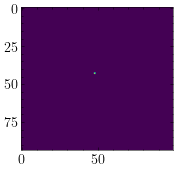

In [117]:
params = [1.86, 0.21, 0.03, 1.5, 1.28, -0.15, 0.53]
# params = [1.6, 0.21, 0.03, 1.5, 1.28, 0.0, 0.02]
quad = QuadPseudoNIELensModel(x_image, y_image, 0.05)
beta_mean = np.mean(quad.backward_pass(params), axis=1)
beta = np.column_stack(quad.backward_pass(params))
# beta = np.column_stack(quad.backward_pass(params))[0]
beta_std = np.std(np.column_stack(quad.backward_pass(params)), axis=0)
fov_source = fov/2
# make fov of source plane about half as small
# source grid
Ns = N//2 # also make grid with about 4 times less pixel
Ms = M//2
ys = np.linspace(-1, 1, Ms) * fov_source
xs = np.linspace(-1, 1, Ns) * fov_source
xs, ys = np.meshgrid(xs, ys)
source_grid = np.column_stack([ys.ravel(), xs.ravel()])
source = np.zeros_like(xs)
for b in beta:
    rhos = np.hypot(xs - b[0], ys - b[1])
    source += np.exp(-0.5 * rhos**4/0.000001)
    break
plt.imshow(source)
beta_mean

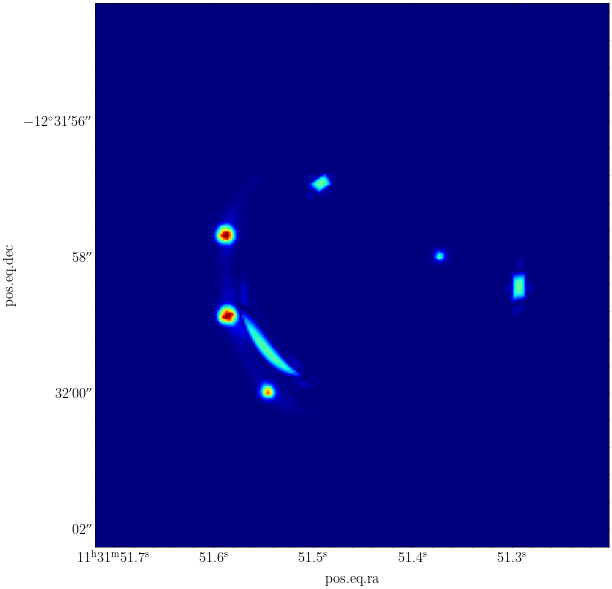

In [118]:
I_reconstructed = quad.lens_image(params, source.ravel(), source_grid, lens_grid).reshape(im.shape)
# I_reconstructed = convolve2d(I_reconstructed, psf, mode="same")
residual = np.square(im - 1000*I_reconstructed)
# residual = I_reconstructed
plt.figure(figsize=(10, 10))
plt.subplot(projection=wcs)
plt.imshow(residual, cmap="jet", norm=ImageNormalize(stretch=LogStretch()))
plt.savefig("best_fit_resiudal.png")

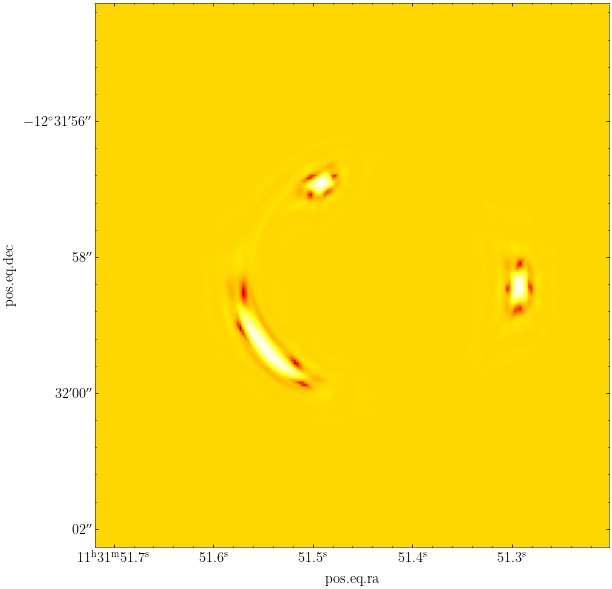

In [119]:
plt.figure(figsize=(10, 10))
plt.subplot(projection=wcs)
plt.imshow(I_reconstructed, cmap="hot", norm=ImageNormalize(stretch=LogStretch()))
plt.savefig("best_fit.png")